Initializing staff

In [1]:
import numpy as np
import scipy.integrate as integrate
import lhapdf
import ROOT

Welcome to JupyROOT 6.28/04


Setting up constants

In [2]:
s_h = 27**2 # in GeV (TeV)
p_t = [1,2,3,4]#[0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00] #GeV
i_ = [-4,-3,-2,-1,1,2,3,4]
j_ = [-4,-3,-1,-2,2,1,3,4]
alpha_em=1./137
const = 0.04 * pow(10, 7-3) #* np.pi * alpha_em * alpha_em

Setting up pdf sets

In [3]:
pdfs = [lhapdf.mkPDF("NNPDF23_nlo_as_0118", 0), lhapdf.mkPDF("nNNPDF20_nlo_as_0118_D2", 0), lhapdf.mkPDF("cteq6l1", 0)]

LHAPDF 6.5.4 loading /usr/share/lhapdf/LHAPDF/NNPDF23_nlo_as_0118/NNPDF23_nlo_as_0118_0000.dat
NNPDF23_nlo_as_0118 PDF set, member #0, version 6; LHAPDF ID = 229800
LHAPDF 6.5.4 loading /usr/share/lhapdf/LHAPDF/nNNPDF20_nlo_as_0118_D2/nNNPDF20_nlo_as_0118_D2_0000.dat
nNNPDF20_nlo_as_0118_D2 PDF set, member #0, version 1; LHAPDF ID = 30010300
LHAPDF 6.5.4 loading /usr/share/lhapdf/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042


Setting up Histos

In [4]:
hist = ROOT.TH1D("hist","hist",1000,0,0.1)

NLO correction function 

In [23]:
def corr_func(z_min,p=1):
    corr = lambda z: 2*np.log(p*(1-z))*(1+(1-z)**2)/z+z
    
    return integrate.quad(corr, z_min, 0.99, epsrel=0.05)[0]
    

In [28]:
print(corr_func(0.0,0.25))

-230.4515241546877


/tmp/ipykernel_2813699/1608129978.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(corr, z_min, 0.99, epsrel=0.05)[0]


Function for Compton and annihilation cross-section

In [7]:
def compton_anih_crossection(y_2, y_1, p, iset1, iset2, isospin1, isospin2):

    #if y_1<0: print("WTF")
    if abs(y_1)>2 or y_2>2: return 0.
        
    x_1 = (2*p/np.sqrt(s_h))* np.exp((y_1 + y_2)/2)*np.cosh(abs((y_1-y_2)/2))
    x_2 = (2*p/np.sqrt(s_h))* np.exp(-(y_1 + y_2/2))*np.cosh(abs((y_1-y_2)/2))
    #hist.Fill(x_1*x_2)
    s = x_1*x_2*s_h

    z_min = max(x_1,x_2)
    
    if np.all( [x_1 > 0 , x_1 < 1 , x_2 > 0 , x_2 < 1, 1. - 4*(p)**2/s > 0] ):
        
        cos_theta = np.sqrt(1 - 4*(p)**2/s)
        u = (-1*s/2)*(1 + cos_theta)
        t = (-1*s/2)*(1 - cos_theta)
        Q2 = -t
        
        pdf1 = pdfs[iset1]
        pdf2 = pdfs[iset2]
        alpha_s = 0.5*(pdf1.alphasQ2(Q2)+pdf2.alphasQ2(Q2))

        sigma=0.
        for iquark in range(len(i_)):
            i1, i2 = i_[iquark], i_[iquark]
            if isospin1==1: i1 = j_[iquark]
            if isospin2==1: i2 = j_[iquark]
            
            eq2 = (1. + (i_[iquark]+1)%2)**2/9.
            
            pdf_i = max(pdf1.xfxQ2(i1, x_1, Q2)/x_1,0.)
            pdf_j = max(pdf2.xfxQ2(21, x_2, Q2)/x_2,0.)
            pdf_k = max(pdf2.xfxQ2(-i2, x_2, Q2)/x_2,0.)
            pdf_i2 = max(pdf2.xfxQ2(i2, x_2, Q2)/x_2,0.)
            pdf_j2 = max(pdf1.xfxQ2(21, x_1, Q2)/x_1,0.)
        
            sigma_compton_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s**2)*((s**2 + u**2)/(4*u*s))

            sigma_anihhil_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s**2)*((t**2 + u**2)/(4*t*s))
            
            sigma += pdf_i*pdf_j*sigma_compton_dt + pdf_i2*pdf_j2*sigma_compton_dt
            sigma += pdf_i*pdf_k*sigma_anihhil_dt
#----------------------------end of lavour cycle------------------------------
        z_min = max(x_1,x_2)
        corr = alpha_s*corr_func(z_min)/(2*np.pi)
        if corr<-1: print(1+corr)
        
        return  sigma*const*(1+corr)
    return 0.

$\tau=x_1\cdot x_2$,    $y=(1/2)ln{x_1/x_2}$,    $x_{1,2}=\sqrt{\tau}e^{\pm y}$

In [8]:
def compton_anih_crossection1(y, tau, p, iset1, iset2, isospin1, isospin2):

    #if abs(y)>0.5: return 0.
    #print(tau)
    x_1 = np.sqrt(tau) * np.exp(+y)
    x_2 = np.sqrt(tau) * np.exp(-y)
    
    #hist.Fill(x_1*x_2)
    s = x_1*x_2*s_h
    
    if np.all( [x_1 > 0 , x_1 < 1 , x_2 > 0 , x_2 < 1, 1. - 4*(p)**2/s > 0] ):
        
        cos_theta = np.sqrt(1 - 4*(p)**2/s)
        u = (-1*s/2)*(1 + cos_theta)
        t = (-1*s/2)*(1 - cos_theta)
        Q2 = -t
        
        pdf1 = pdfs[iset1]
        pdf2 = pdfs[iset2]
        alpha_s = 0.5*(pdf1.alphasQ2(Q2)+pdf2.alphasQ2(Q2))

        sigma=0.
        for iquark in range(len(i_)):
            i1, i2 = i_[iquark], i_[iquark]
            if isospin1==1: i1 = j_[iquark]
            if isospin2==1: i2 = j_[iquark]
            
            eq2 = (1. + (i_[iquark]+1)%2)**2/9.
            
            pdf_i = max(pdf1.xfxQ2(i1, x_1, Q2)/x_1,0.)
            pdf_j = max(pdf2.xfxQ2(21, x_2, Q2)/x_2,0.)
            pdf_k = max(pdf2.xfxQ2(-i2, x_2, Q2)/x_2,0.)
            pdf_i2 = max(pdf2.xfxQ2(i2, x_2, Q2)/x_2,0.)
            pdf_j2 = max(pdf1.xfxQ2(21, x_1, Q2)/x_1,0.)
        
            sigma_compton_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s**2)*((s**2 + u**2)/(4*u*s))

            sigma_anihhil_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s**2)*((t**2 + u**2)/(4*t*s))
            
            sigma += pdf_i*pdf_j*sigma_compton_dt + pdf_i2*pdf_j2*sigma_compton_dt
            sigma += pdf_i*pdf_k*sigma_anihhil_dt
#----------------------------end of lavour cycle------------------------------
        z_min = max(x_1,x_2)
        corr = alpha_s*corr_func(z_min)/(2*np.pi)
        if corr<-1: print(1+corr)
        
        return  sigma*const*(1+corr)
    return 0.

Testing

In [9]:
print(compton_anih_crossection(0.01,0.5,1,0,0,0,0))

0.0


Integration Bounds and accuracy

In [10]:
def bounds_y(p, iset1, iset2, isospin1, isospin2):
    return [np.log(p/np.sqrt(s_h)), np.log(np.sqrt(s_h)/p)]
        
def bounds_x(y_1, p, iset1, iset2, isospin1, isospin2):
    return [np.log(p/(np.sqrt(s_h) - p*np.exp(-y_1))), np.log((np.sqrt(s_h) - p*np.exp(-y_1))/p)]

def bounds_y1(p, iset1, iset2, isospin1, isospin2):
    return [4.*p**2/s_h, 1]
        
def bounds_x1(tau, p, iset1, iset2, isospin1, isospin2):
    return [-0.5*abs(np.log(tau)), +0.5*abs(np.log(tau))]
    
def opts0(y_1, p, iset1, iset2, isospin1, isospin2):
    return {'epsrel' : 0.05}

def opts1(p, iset1, iset2, isospin1, isospin2):
    return {'epsrel' : 0.05}                

def opts10(y_1, p, iset1, iset2, isospin1, isospin2):
    return {'epsrel' : 0.5}

def opts11(p, iset1, iset2, isospin1, isospin2):
    return {'epsrel' : 0.5}     

Integration function

In [11]:
def integration_cs(pT,iset1,iset2,isospin1,isopin2):
    result=[]
    for p in pT:
        integral = integrate.nquad(compton_anih_crossection1, [bounds_x1, bounds_y1], args=[p,iset1,iset2,isospin1,isopin2], opts=[opts10,opts11])
        #integral = integrate.nquad(compton_anih_crossection, [bounds_x, bounds_y], args=[p,iset1,iset2,isospin1,isopin2], opts=[opts0,opts1])
        #print(p,i,integral)
        result.append(integral)   
                
    return result

Parallel calculating for $p+p$

Drawing histos

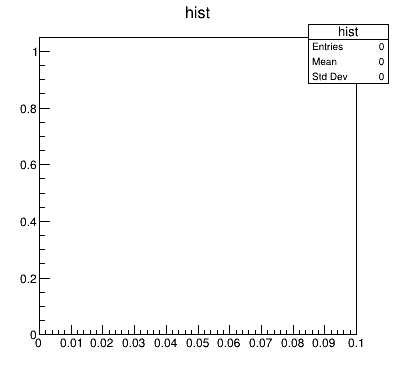

In [12]:
c1 = ROOT.TCanvas("c1","c1",400,400)
hist.Draw()
c1.Draw()
#%jsroot on

In [13]:
import multiprocess as mp

Ntr = 16
pT = [0.25*i+0.25 for i in range(Ntr)]
print(pT)
pool = mp.Pool(Ntr)

hist_array = pool.starmap(integration_cs, [([pT[i]], 0,0,0,0) for i in range(Ntr)])
    
pool.close()   

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Parallel calculating for $p+n$

In [14]:
pool_pn = mp.Pool(Ntr)

hist_array_pn = pool_pn.starmap(integration_cs, [([pT[i]], 0,0,0,1) for i in range(Ntr)])
    
pool.close()   

/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Parallel calculating for $n+p$

In [15]:
pool_np = mp.Pool(Ntr)

hist_array_np = pool_np.starmap(integration_cs, [([pT[i]], 0,0,1,0) for i in range(Ntr)])
    
pool.close()   

/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Parallel calculating for $n+n$

In [16]:
pool_nn = mp.Pool(Ntr)

hist_array_nn = pool_nn.starmap(integration_cs, [([pT[i]], 0,0,1,1) for i in range(Ntr)])
    
pool.close()   

/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Parallel calculating for $d+d$

In [17]:
pool_dd = mp.Pool(Ntr)

hist_array_dd = pool_dd.starmap(integration_cs, [([pT[i]], 1,1,0,0) for i in range(Ntr)])
    
pool.close()   

/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [18]:
pool_pd = mp.Pool(Ntr)

hist_array_pd = pool_pd.starmap(integration_cs, [([pT[i]], 0,1,0,0) for i in range(Ntr)])
    
pool.close()   

pool_dp = mp.Pool(Ntr)

hist_array_dp = pool_dp.starmap(integration_cs, [([pT[i]], 1,0,0,0) for i in range(Ntr)])
    
pool.close()   

/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably

In [19]:
print(hist_array_pd)
print(hist_array_dp)

[[(3.7946182746165946, 6262.621980962824)], [(3.6986149527543346, 170.42353588881247)], [(2.6422182223403685, 293.2116766532524)], [(1.2018811402289313, 137.4800563518354)], [(0.41985918815665835, 11.610360710093333)], [(0.14201550843101127, 0.7443064478119604)], [(0.052175540598545955, 0.6145182447488192)], [(0.020635447606416175, 0.13496846853944752)], [(0.008674744828906357, 0.024113882203612932)], [(0.0038353810466034946, 0.018216163535779796)], [(0.0017680109899396509, 0.010295449976579638)], [(0.0008437574177833052, 0.001180047726778629)], [(0.00041443900122655765, 0.0003927569547718263)], [(0.00020856812709061073, 0.00020119593254580575)], [(0.00010710305699951961, 0.00013550052148762694)], [(5.591990099481393e-05, 0.00011939288006610994)]]
[[(3.794618274616594, 6262.621980962824)], [(3.698614952754334, 170.42353588881247)], [(2.6422182223403685, 293.2116766532524)], [(1.2018811402289313, 137.48005635183543)], [(0.41985918815665835, 11.61036071009617)], [(0.14201550843101127, 0.

Factors

In [20]:
print(hist_array)
print(hist_array_pn)
print(hist_array_np)
res_iso=[]
for ival in range(len(hist_array)):
    res_iso.append(0.25*(hist_array[ival][0][0]+hist_array_pn[ival][0][0]+hist_array_np[ival][0][0]+hist_array_nn[ival][0][0])/(hist_array[ival][0][0]+1e-20))
print("pT:1.0,2.0,3.0,4.0",res_iso)
res=[]
for ival in range(len(hist_array)):
    res.append(hist_array_dd[ival][0][0]/(hist_array[ival][0][0]+1e-20))
print("pT:1.0,2.0,3.0,4.0",res)
cs_tot=0
for ival in range(len(hist_array)):
    cs_tot+=hist_array_dd[ival][0][0]*(0.25+0.25*ival)
print(cs_tot*0.25)

[[(2.481773119924516, 6082.982859428517)], [(2.315875265676694, 588.4235857324635)], [(1.9263512691756874, 62.85159026176612)], [(1.1632558318804624, 126.64283152578547)], [(0.4615317857361637, 9.616845610075526)], [(0.15815880881654054, 0.7280829320075689)], [(0.058443941381634966, 0.41732025776251924)], [(0.023233173109457404, 0.10495031714099617)], [(0.009812669849600355, 0.023406729370959896)], [(0.00435775209305636, 0.01743162454589687)], [(0.0020169137615786027, 0.011016988970078216)], [(0.0009659296554504055, 0.0017551933853047334)], [(0.00047574859559494626, 0.00023735216799611789)], [(0.0002398462961831901, 0.00020134883183131632)], [(0.00012322826886971696, 0.00018412075425091074)], [(6.426144197116004e-05, 0.00016555284073874627)]]
[[(2.3624237432265884, 4693.136612489179)], [(2.1523372085059047, 586.4927723542912)], [(1.7556985712117104, 72.62590397576334)], [(1.0407112873918098, 114.41851076747298)], [(0.4058931201492063, 8.097083317630696)], [(0.13713947514872832, 0.67428